# Tabular Data Regression Example

In this example, we demonstrate how to use dlpy to build a simple neural network for tabular data regression problems. 

The california housing dataset we used here is contained in the sklearn package. More details about the data can be found here:https://scikit-learn.org/stable/datasets/index.html#california-housing-dataset

Key steps involved:
1. Upload data to the server
2. Build and train a fully connected feedforward neural network model with dlpy.
3. Predict on the testing dataset.
4. Evaluate the training and testing loss

### 1. Import python modules

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
from sklearn.datasets import fetch_california_housing #The dataset is from sklearn package, with version >= 0.20.1
from swat.cas import datamsghandlers
from swat import CAS, CASTable
from dlpy import Model, Sequential
from dlpy.model import Optimizer, AdamSolver
from dlpy.layers import * 
%matplotlib inline

### 2. Connect to CAS server

In [2]:
conn = CAS(host_name, port_number)

### 3. Load examples dataset from scikit-learn

In [3]:
# load the california housing data
california_housing = fetch_california_housing()

# Get data into two pandas dataframes for the predictors(ch_x_df) and target(ch_y_df). 
ch_x_df = pd.DataFrame(california_housing['data'], columns=california_housing['feature_names'])
ch_y_df = pd.DataFrame(california_housing['target'], columns=['house_value'])

# Concatenate the data into one dataframe
ch_df = pd.concat([ch_x_df, ch_y_df], axis=1)

In [4]:
ch_df.loc[:10]

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,house_value
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422
5,4.0368,52.0,4.761658,1.103627,413.0,2.139896,37.85,-122.25,2.697
6,3.6591,52.0,4.931907,0.951362,1094.0,2.128405,37.84,-122.25,2.992
7,3.1200,52.0,4.797527,1.061824,1157.0,1.788253,37.84,-122.25,2.414
8,2.0804,42.0,4.294118,1.117647,1206.0,2.026891,37.84,-122.26,2.267
9,3.6912,52.0,4.970588,0.990196,1551.0,2.172269,37.84,-122.25,2.611


### 4. Upload the pandas dataframe to server

In [5]:
handler = datamsghandlers.PandasDataFrame(ch_df)
conn.addtable(table='ch_df', replace=True, **handler.args.addtable)
tbl = conn.CASTable(name='ch_df')

### 5. Split the data in CAS

Here we show the train-test spliting using the 'sampling' action in CAS. It is a preferred method, if the data is large and hosted on the server side. 

In [6]:
# load the sampling action set
conn.loadactionset(actionSet='sampling', _messagelevel='error')

# do random sampling, and add a new ('partind') column to the original table.
# partind column have randomly selected 20% entries marked as indicator 1 for testing, 
# and the rest 80% are marked as 0 for training
sample_result = conn.sampling.srs(tbl, sampPct=20, 
                                  partInd=True, seed=1234,
                                  output={'casOut':{'name':tbl.name, 'replace':True}, 
                                          'copyVars':'ALL', 'partIndName':'partind'})

# get the train and test dataset
train_tbl = tbl.query('partind = 0')
test_tbl = tbl.query('partind = 1')

NOTE: Using SEED=1234 for sampling.


### 6. Build two layer fully connected neural network

Network specifications:
1. One dense layer
2. Activation function: relu
3. Number of layers: 2
3. Number of neurons: first layer with 30 neurons and second layer with 10 neurons.
4. Output layer activation function: identity.
5. Output layer loss function: normal error (squred loss).

In [7]:
model1 = Sequential(conn, model_table='Simple_DNN1')
model1.add(InputLayer(std='STD'))
model1.add(Dense(30, act='relu'))
model1.add(Dense(10, act='relu'))
model1.add(OutputLayer(act='identity', error='normal')) 

NOTE: Input layer added.
NOTE: Fully-connected layer added.
NOTE: Fully-connected layer added.
NOTE: Output layer added.
NOTE: Model compiled successfully.


### 7. Train fully connected neural network

Here we specify the optimizer to show a **scheduled training approach** (polynomial decay. The classification example shows a case using stepwise decay learning policy):

We use `learning_rate_policy='poly'` to specify polynomial learning rate decreasing policy. The power is `power=0.5`, which means the learning rate follows the function $initial\_learning\_rate*(1 - \frac{epoch}{max\_epochs})^{power}$. In addition, we set `log_level=2` to visualize the training log.

In [8]:
optimizer = Optimizer(algorithm=AdamSolver(learning_rate=0.001, learning_rate_policy='poly', power=0.5),
                      mini_batch_size=4, seed=1234, max_epochs=50, log_level=2)

result = model1.fit(train_tbl, inputs=ch_x_df.columns.tolist(), target='house_value', optimizer=optimizer)

NOTE: Training from scratch.
NOTE:  The Synchronous mode is enabled.
NOTE:  The total number of parameters is 591.
NOTE:  The approximate memory cost is 1.00 MB.
NOTE:  Loading weights cost       0.00 (s).
NOTE:  Initializing each layer cost       0.00 (s).
NOTE:  The total number of threads on each worker is 32.
NOTE:  The total mini-batch size per thread on each worker is 4.
NOTE:  The maximum mini-batch size across all workers for the synchronous mode is 128.
NOTE:  Target variable: house_value
NOTE:  Number of input variables:     8
NOTE:  Number of numeric input variables:      8
NOTE:  Epoch Learning Rate        Loss  Fit Error   Time(s)
NOTE:  0         0.001           1.315      2.629     0.02
NOTE:  1         0.001          0.3881     0.7761     0.02
NOTE:  2         0.001          0.3095      0.619     0.02
NOTE:  3         0.001          0.2545      0.509     0.02
NOTE:  4         0.001          0.2249     0.4498     0.02
NOTE:  5        0.0009          0.2108     0.4215    

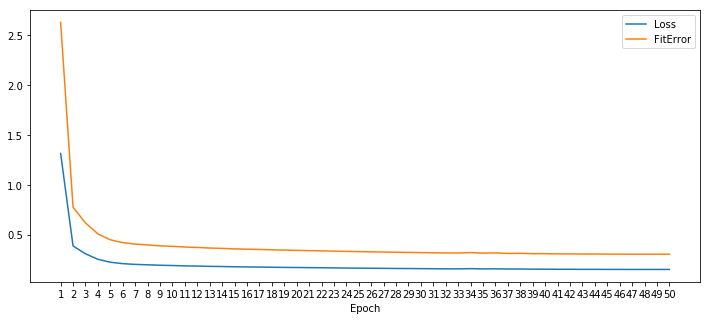

In [9]:
# Plot the training history.
model1.plot_training_history()

### 8. Show fitted and testing result

In [10]:
fitted_result = model1.predict(train_tbl)
print(fitted_result['ScoreInfo'])

                         Descr         Value
0  Number of Observations Read         16512
1  Number of Observations Used         16512
2           Mean Squared Error      0.305471
3                   Loss Error      0.152735


In [11]:
test_result = model1.predict(test_tbl)
test_table = model1.valid_res_tbl
print(test_result['ScoreInfo'])

                         Descr         Value
0  Number of Observations Read          4128
1  Number of Observations Used          4128
2           Mean Squared Error      0.294407
3                   Loss Error      0.147203
